### Imports

In [1]:
import numpy as np

In [2]:
import torch
from torch.utils.data import Dataset

In [3]:
from torch import nn

In [4]:
from torch.nn import functional

Library where Mackey-Glass timeseries realised: [`reservoirpy`](https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.datasets.mackey_glass.html)

In [5]:
from reservoirpy.datasets import mackey_glass

`svetlanna`

In [6]:
from svetlanna import Wavefront
from svetlanna import SimulationParameters
from svetlanna.parameters import BoundedParameter

In [7]:
from svetlanna import elements
from svetlanna.recurrent_reservoir import RecurrentReservoir
from svetlanna.detector import Detector

In [8]:
from svetlanna.setup import LinearOpticalSetup

Visualization

In [9]:
from tqdm import tqdm

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

## Mackey-Glass timeseries (data)

Equation from [`reservoirpy`](https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.datasets.mackey_glass.html) documentation:

$$
\frac{x}{t}= \frac{a x(t-\tau)}{1 + x(t-\tau)^n} - bx(t)
$$


In [11]:
N_STEPS = 3000

LAST_STEPS_TO_TEST = 500

In [12]:
# generate timeseries using `reservoirpy` library

mg_timeseries = mackey_glass(
    N_STEPS, 
    tau=17,  # Mackey-Glass parameters
    a=0.2, b=0.1, 
    n=10, 
    x0=1.2, 
    h=1.0, 
    seed=98  # for reproducibility
)

In [13]:
max_val = 1.4
min_val = 0.3

In [14]:
mg_timeseries_norm = (mg_timeseries - min_val) / (max_val - min_val)

In [15]:
# train ad test parts of time series
ALL_MG = mg_timeseries_norm[:]

TRAIN_MG = mg_timeseries_norm[:-LAST_STEPS_TO_TEST]
TEST_MG = mg_timeseries_norm[-LAST_STEPS_TO_TEST - 1:]

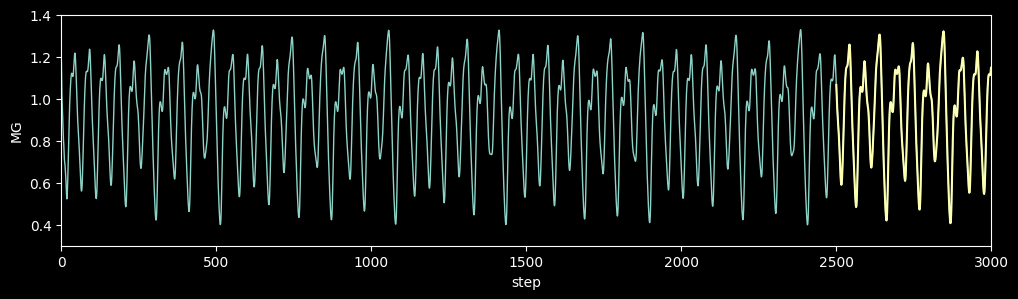

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

time = np.arange(N_STEPS)
ax.plot(time, mg_timeseries, lw=1,)
ax.plot(time[-LAST_STEPS_TO_TEST:], mg_timeseries[-LAST_STEPS_TO_TEST:], )

# axes titles
ax.set_xlabel('step')
ax.set_ylabel('MG')

# axes settings
ax.set_xlim([0, N_STEPS])
ax.set_ylim([min_val, max_val])  # min / max values?

plt.show()

### Normalized timeseries (values in range $[0, 1]$)

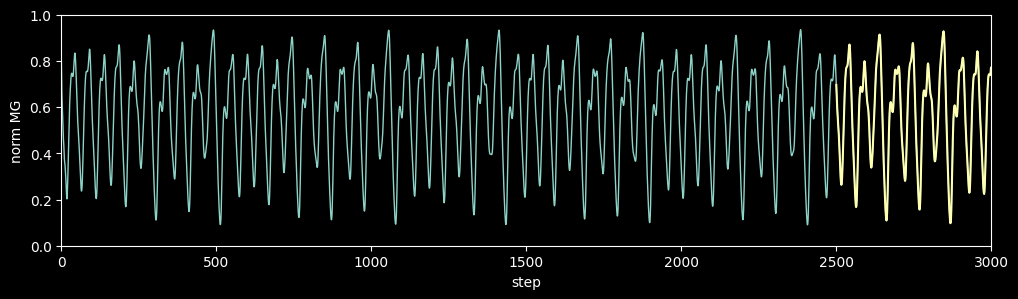

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(time, mg_timeseries_norm, lw=1,)
ax.plot(time[-LAST_STEPS_TO_TEST:], mg_timeseries_norm[-LAST_STEPS_TO_TEST:], )

# axes titles
ax.set_xlabel('step')
ax.set_ylabel('norm MG')

# axes settings
ax.set_xlim([0, N_STEPS])
ax.set_ylim([0, 1])  # min / max values?

plt.show()

## Timeseries to optics

### Simulation parameters

In [18]:
SAMPLING = 200  # number of steps

In [19]:
working_wavelength = 250 * 1e-6  # in [m]

In [20]:
x_layer_size_m = 5 * 1e-2  # try to make a 1d wavefront
y_layer_size_m = 5 * 1e-2  # in [m] 

x_layer_nodes = SAMPLING
y_layer_nodes = SAMPLING  # number of stems between max and min values to encode a time series

In [21]:
print(f'Neuron size = {y_layer_size_m / SAMPLING * 1e6:.3f} um')

Neuron size = 250.000 um


In [22]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

### Timeseries value $\rightarrow$ `Wavefront`

In [23]:
INIT_BEAM = Wavefront.gaussian_beam(
    simulation_parameters=SIM_PARAMS,
    waist_radius=1 * 1e-2,  # [m]
)

In [24]:
def val_to_wavefront(sim_params, value):
    """
    Changes an intensity of INIT_BEAM according to a value (value --> intensity).

    Arguments:
    ----------
    value: float
        A value from a normalized time series (from 0 to 1).
    """

    return INIT_BEAM * (value) ** (1 / 2)

# Optical encoder

## Optical Recurrent Reservoir

<div>
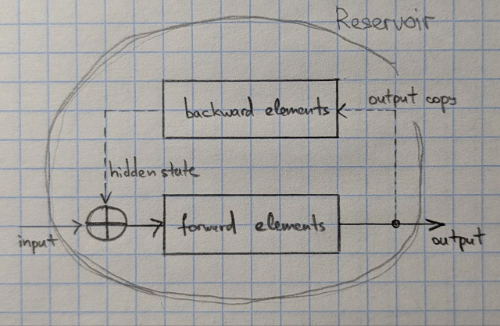
</div>

### Forward part

<div>
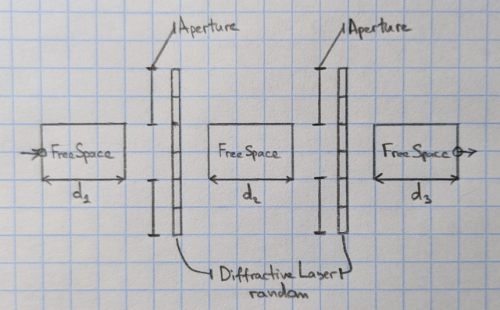
</div>

In [25]:
MAX_PHASE = 2 * torch.pi
FREESPACE_METHOD = 'AS'

In [26]:
# to define a forward elements for a reservoir
fwd_elems_difflayers_seeds = [12]  # len = N: number of diffractive layers in forward elements
fwd_elems_freespaces_dists = [3.00 * 1e-2, 3.00 * 1e-2] # len = N + 1

In [27]:
# adds apertures BEFORE diffractive layers in forward 
APERTURES = True
APERTURE_SZ = (60, 60)

if APERTURES:
    # equal masks for all apertures (select a part in the middle)
    APERTURE_MASK = torch.ones(size=APERTURE_SZ)

    y_nodes, x_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))
    y_mask, x_mask = APERTURE_MASK.size()
    pad_top = int((y_nodes - y_mask) / 2)
    pad_bottom = y_nodes - pad_top - y_mask
    pad_left = int((x_nodes - x_mask) / 2)
    pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
    
    # padding transform to match aperture size with simulation parameters     
    APERTURE_MASK = functional.pad(
        input=APERTURE_MASK,
        pad=(pad_left, pad_right, pad_top, pad_bottom),
        mode='constant',
        value=0
    )

In [28]:
def get_elements_list(sim_params, distances, seeds, apertures=True, freespace_method='AS'):
    """
    Elements list starts and ends with FreeSpace.
    FreeSpaces alternate with DiffractiveLayer.
    """
    lst = []
    # FIRST FREE SPACE
    lst.append(
        elements.FreeSpace(
            simulation_parameters=sim_params,
            distance=distances[0],  # in [m], distance is not learnable!
            method=freespace_method
        )
    )

    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))
    for dist, seed in zip(distances[1:], seeds):
        if apertures:
            # ADD SQUARE APERTURE BEFORE DIFFRACTIVE LAYER
            lst.append(
                elements.Aperture(
                    simulation_parameters=sim_params,
                    mask=APERTURE_MASK,
                )
            )

        # DIFFRACTIVE LAYER
        lst.append(
            elements.DiffractiveLayer(
                simulation_parameters=sim_params,
                mask=torch.rand(
                    size=(y_nodes, x_nodes),
                    generator=torch.Generator().manual_seed(seed)
                ) * MAX_PHASE,
                mask_norm=1
            )
        )
        # FREESPACE
        lst.append(
            elements.FreeSpace(
                simulation_parameters=sim_params,
                distance=dist,  # in [m], distance is not learnable!
                method=freespace_method
            )
        )

    return lst

In [29]:
forward_elements = get_elements_list(
    SIM_PARAMS, 
    fwd_elems_freespaces_dists,
    fwd_elems_difflayers_seeds,
    apertures=APERTURES,
    freespace_method=FREESPACE_METHOD
)

### Backward part (only FreeSpace for now)

In [30]:
backward_elements = [
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=sum(fwd_elems_freespaces_dists),  # in [m], distance is not learnable!
        method=FREESPACE_METHOD
    )
]

### Reservoir

In [31]:
recurrent_reservoir = RecurrentReservoir(
    SIM_PARAMS,
    forward_elements, backward_elements,
    attenuation_forward=0.3, attenuation_backward=0.1,  # APERTURES CAN WORK AS ATTENUATION!
)

## Masking (mask before a reservoir)

In [32]:
MASKING_SEED = 123

In [33]:
MASKING_APERTURE = elements.DiffractiveLayer(
    simulation_parameters=SIM_PARAMS,
    mask=torch.rand(
        size=(y_layer_nodes, x_layer_nodes),
        generator=torch.Generator().manual_seed(MASKING_SEED)
    ),
)

## Optical encoder: all together

<div>
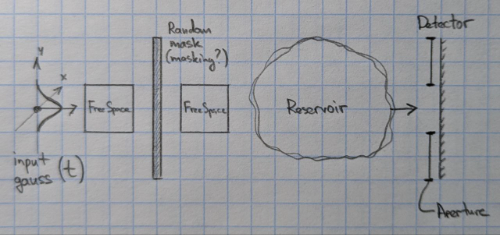
</div>

In [34]:
RESERVOIR_IND = 3  # index of a Reservoir in encoder elements

encoder_elements = [
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=1.00 * 1e-2,  # in [m], distance is not learnable!
        method=FREESPACE_METHOD
    ),
    MASKING_APERTURE,  # <-- MASKING!!!
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=1.00 * 1e-2,  # in [m], distance is not learnable!
        method=FREESPACE_METHOD
    ),
    recurrent_reservoir,  # <-- RECURRENT RESERVOIR
    elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=2.00 * 1e-2,  # in [m], distance is not learnable!
        method=FREESPACE_METHOD
    ),
]

# ADD APERTURE BEFORE DETECTOR
if APERTURES:
    encoder_elements.append(
        elements.Aperture(
            simulation_parameters=SIM_PARAMS,
            mask=APERTURE_MASK,
        ),  # APERTURE BEFORE DETECTOR?
    )

# ADD DETECTOR
encoder_elements.append(
    Detector(SIM_PARAMS),  # <-- transforms wavefront to intencities tensor
)

In [35]:
optical_encoder = LinearOpticalSetup(
    encoder_elements
)

# TODO: how to reset a hidden state in that case?
# optical_encoder.elements[1].reset_hidden() ???

### Encoded timeseries

In [36]:
decoder_inputs_energy = torch.zeros(size=(len(ALL_MG), ))
optical_encoder.elements[RESERVOIR_IND].reset_hidden()  # reset reservoir hidden state

for ind, X in tqdm(
        enumerate(ALL_MG),
        total=len(ALL_MG),
        desc='Encoding', position=0, leave=True,
    ):
        # to wavefront
        X = val_to_wavefront(SIM_PARAMS, X.item())
        # through reservoir
        X = optical_encoder.forward(X)

        decoder_inputs_energy[ind] = X.sum()

Encoding: 100%|██████████████████████████████████████████████████████████████████████████| 3000/3000 [00:45<00:00, 66.15it/s]


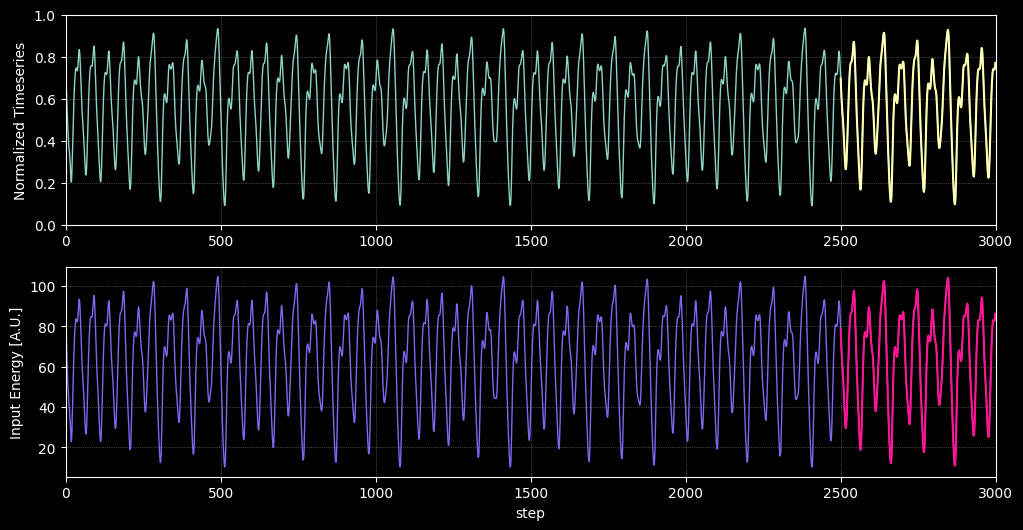

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# plot time series
axs[0].plot(time, mg_timeseries_norm, lw=1,)
axs[0].plot(time[-LAST_STEPS_TO_TEST:], mg_timeseries_norm[-LAST_STEPS_TO_TEST:], )

# plot encoded wavefronts energies
axs[1].plot(time, decoder_inputs_energy, lw=1, c='mediumslateblue')
axs[1].plot(time[-LAST_STEPS_TO_TEST:], decoder_inputs_energy[-LAST_STEPS_TO_TEST:], c='deeppink')

# axes titles
axs[0].set_ylabel('Normalized Timeseries')

axs[1].set_xlabel('step')
axs[1].set_ylabel('Input Energy [A.U.]')

# axes settings
axs[0].set_xlim([0, N_STEPS])
axs[0].set_ylim([0, 1])

axs[1].set_xlim([0, N_STEPS])

# grid
axs[0].grid(which='both', alpha=0.5, lw=0.5, ls='dotted')
axs[1].grid(which='both', alpha=0.5, lw=0.5, ls='dotted')

plt.show()

# Torch decoder

In [38]:
class TorchNetwork(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        y = self.linear_stack(x)
        return y

In [39]:
lu_corner = torch.nonzero(APERTURE_MASK)[0]
rb_corner = torch.nonzero(APERTURE_MASK)[-1]  # corners of square aperture


class TorchConvNetwork(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=3, 
                kernel_size=(5, 5), padding='valid',
            ),  # OUT: size is same as input + 3 channels
            nn.ReLU(),
            # TODO: add pooling?
    		nn.MaxPool2d(kernel_size=(5, 5), stride=(2, 2)),
            nn.Conv2d(
                in_channels=3, out_channels=1, 
                kernel_size=(3, 3), padding='valid',
            ),  # OUT: size is same as input + 3 channels
            nn.ReLU(),
            # TODO: add pooling?
    		nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        )

        flatten_output_size = 144

        self.linear_stack = nn.Sequential(
            nn.Linear(flatten_output_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        if APERTURES:
            x = x[lu_corner[0]:rb_corner[0] + 1, lu_corner[1]:rb_corner[1] + 1]
        else: 
            print('You should add aperture before a Detector!')
            Exception()

        x = x.unsqueeze(0)
        x = self.conv_stack(x)
        
        x = torch.flatten(x, 1)
        
        y = self.linear_stack(x)
        return y

In [40]:
torch.manual_seed(78)

torch_decoder = TorchConvNetwork(input_size=SAMPLING)

# Training

In [41]:
optimizer = torch.optim.Adam(
    params=torch_decoder.parameters(),  # NETWORK PARAMETERS!
    lr=5 * 1e-7
)

In [42]:
loss_func = nn.MSELoss()
loss_func_name = 'MSE'

In [43]:
n_epochs = 20
print_each = 2

### First version

In [44]:
epoch_train_losses = []
epoch_test_losses = []

torch.manual_seed(198)

for epoch in range(n_epochs):
    show_process = False
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # train info
        print(f'Epoch #{epoch + 1}: ', end='')
        show_process=True
    
    # --------------------------------------------------------------------------- TRAIN
    torch_decoder.train()  # activate 'train' mode of a detector
    optical_encoder.elements[RESERVOIR_IND].reset_hidden()  # reset reservoir hidden state
    
    train_losses = []  # to store loss for each batch

    for X, Y in tqdm(
        zip(TRAIN_MG[:-1], TRAIN_MG[1:]),
        total=len(TRAIN_MG[:-1]),
        desc='Train', position=0, leave=True,
        disable=not show_process
    ):
        # to wavefront
        X = val_to_wavefront(SIM_PARAMS, X.item())
        # through reservoir
        X = optical_encoder.forward(X)
        
        # through decoder
        y = torch_decoder(X)  # we need a vector for a decoder!

        # trining part
        loss = loss_func(
            y[0], 
            torch.tensor([Y.item()]).float()  # TARGET
        )
        loss.backward()
        optimizer.step()
        
        # accumulate losses and accuracies for batches
        train_losses.append(loss.item())
    
    # averaged TRAIN losses for an epoch
    epoch_train_losses.append(np.mean(train_losses))        

    # --------------------------------------------------------------------------- TEST
    torch_decoder.eval()  # activate 'eval' mode of a model
    test_losses = []  # to store loss for each batch

    for X, Y in tqdm(
        zip(TEST_MG[:-1], TEST_MG[1:]),
        total=len(TEST_MG[:-1]),
        desc='Test', position=0, leave=True,
        disable=not show_process,
    ):
        # to wavefront
        X = val_to_wavefront(SIM_PARAMS, X.item())
        # through reservoir
        X = optical_encoder.forward(X)

        with torch.no_grad():
            y = torch_decoder(X)
            # loss for a point
            loss = loss_func(
                y[0], 
                torch.tensor([Y.item()]).float()  # TARGET
            )
        
        # accumulate losses
        test_losses.append(loss.item())

    # averaged TRAIN losses for an epoch
    epoch_test_losses.append(np.mean(test_losses))

    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # train info
        print(f'\tTrain {loss_func_name}\t: {epoch_train_losses[-1]:.6f}')
        print(f'\tTest {loss_func_name}\t: {epoch_test_losses[-1]:.6f}')


Epoch #1: 

Test: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 68.15it/s]


	Train MSE	: 0.361218
	Test MSE	: 0.354013
Epoch #2: 

Test: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 76.69it/s]


	Train MSE	: 0.353176
	Test MSE	: 0.345896
Epoch #4: 

Test: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 52.82it/s]


	Train MSE	: 0.330599
	Test MSE	: 0.319910
Epoch #6: 

Test: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 83.63it/s]


	Train MSE	: 0.292766
	Test MSE	: 0.278865
Epoch #8: 

Test: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.67it/s]


	Train MSE	: 0.241595
	Test MSE	: 0.225401
Epoch #10: 

Test: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.75it/s]


	Train MSE	: 0.181621
	Test MSE	: 0.164240
Epoch #12: 

Test: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 116.05it/s]


	Train MSE	: 0.117302
	Test MSE	: 0.100212
Epoch #14: 

Test: 100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 96.28it/s]


	Train MSE	: 0.056781
	Test MSE	: 0.043051
Epoch #16: 

Test: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.65it/s]


	Train MSE	: 0.014759
	Test MSE	: 0.009003
Epoch #18: 

Test: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.71it/s]


	Train MSE	: 0.012323
	Test MSE	: 0.019933
Epoch #20: 

Test: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.87it/s]

	Train MSE	: 0.069868
	Test MSE	: 0.093805


### Plot results

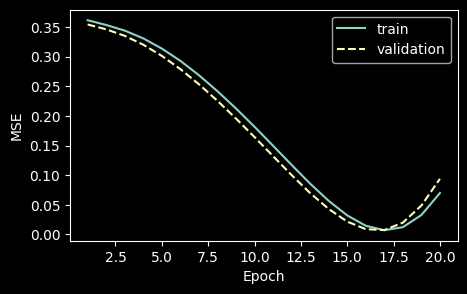

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(range(1, n_epochs + 1), epoch_train_losses, label='train')
ax.plot(range(1, n_epochs + 1), epoch_test_losses, linestyle='dashed', label='validation')

ax.set_ylabel(loss_func_name)
ax.set_xlabel('Epoch')
ax.legend()

# ax.set_ylim(0, 1)

plt.show()

### Timeseries predicting

In [46]:
# --------------------------------------------------------------------------- PREDICTING
torch_decoder.eval()  # activate 'eval' mode of a model

predicted_ts = torch.zeros(size=(ALL_MG[:-1].size, ))

for ind, X in tqdm(
    enumerate(ALL_MG[:-1]),
    total=len(ALL_MG[:-1]),
    desc='Predicting', position=0, leave=True,
):
    # to wavefront
    X = val_to_wavefront(SIM_PARAMS, X.item())
    # through reservoir
    X = optical_encoder.forward(X)

    with torch.no_grad():
        y = torch_decoder(X)
        predicted_ts[ind] = y.item()

Predicting: 100%|███████████████████████████████████████████████████████████████████████| 2999/2999 [00:27<00:00, 107.79it/s]


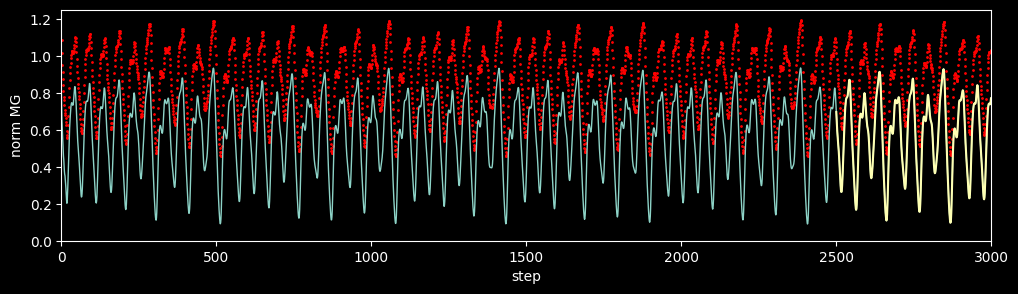

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(time, mg_timeseries_norm, lw=1,)
ax.plot(time[-LAST_STEPS_TO_TEST:], mg_timeseries_norm[-LAST_STEPS_TO_TEST:])

ax.scatter(time[1:], predicted_ts, s=1, c='r')

# axes tiltes
ax.set_xlabel('step')
ax.set_ylabel('norm MG')

# axes settings
ax.set_xlim([0, N_STEPS])
ax.set_ylim([0, 1.25])  # min / max values?

plt.show()